<a href="https://colab.research.google.com/github/Generative-AI-for-Analog-Chip-Design/cap-matrix-predictor/blob/main/MLPipeline_CapacitanceInterconnect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Necessary Library

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pickle
import matplotlib.pyplot as plt
import numpy as np

 # Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# Input Data import and read-out

For reference there is in the open source domain toolchain for the layout that enable to test for interconnection layout: https://github.com/yuchsiao/caplet

An illustration of such interconnection is given as follow :  

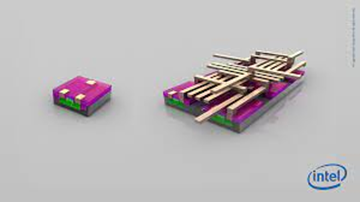


The first step in this Notebook will be to upload a python compressed file (pkl), which contain a dictionary of Data we actually look into that are geometry contain in a key called  'input_arr' and the associated capacitance matrix contained under the key 'cmat', that spans over node number and encode the capacitance value.

In [ ]:
# Assuming the file name is "caplet_test.pkl"
# it must be downloaded from : https://github.com/coustam/test

from google.colab import files
uploaded = files.upload()

Saving caplet_test.pkl to caplet_test.pkl


In [ ]:
# Load data from the uploaded pickle file
import urllib.request
import pickle

data = pickle.load(urllib.request.urlopen('https://github.com/coustam/test/raw/main/caplet_test.pkl'))



4096


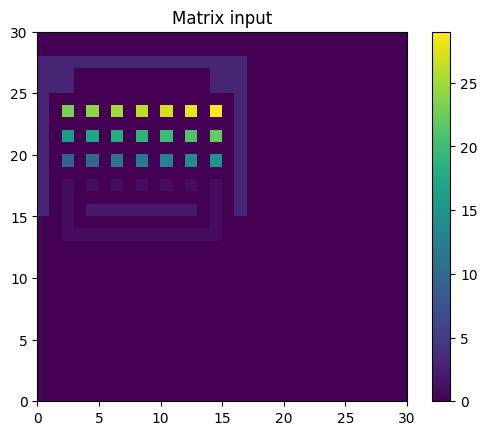

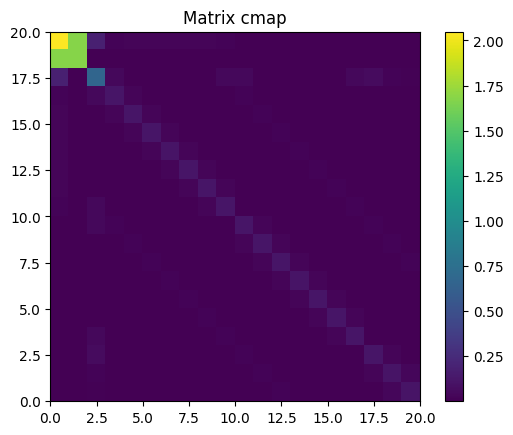

In [ ]:
print(len(data))
c_max = (0,0)
i_max = (0,0)
c = data[0]["cmat"]
p = data[0]["input_arr"]

ph, pw = p.shape
ch, cw = c.shape
        # Pad the input and output tensors to match specified dimensions
padded_p = torch.nn.functional.pad(torch.tensor(p), (0, 30 - pw, 0, 30 - ph))
padded_c = torch.nn.functional.pad(torch.tensor(c), (0, 20 - cw, 0, 20 - ch))

plt.figure()
plt.imshow(padded_p.numpy(), cmap='viridis', extent=[0, padded_p.numpy().shape[1], 0, padded_p.numpy().shape[0]])
plt.title('Matrix input')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(padded_c.numpy(), cmap='viridis', extent=[0, padded_c.numpy().shape[1], 0, padded_c.numpy().shape[0]])
plt.title('Matrix cmap')
plt.colorbar()
plt.show()


Keys of the first dictionary: ['file', 'cmat', 'input_arr']
Matrix for key file (Dictionary 1) is not a valid NumPy array.


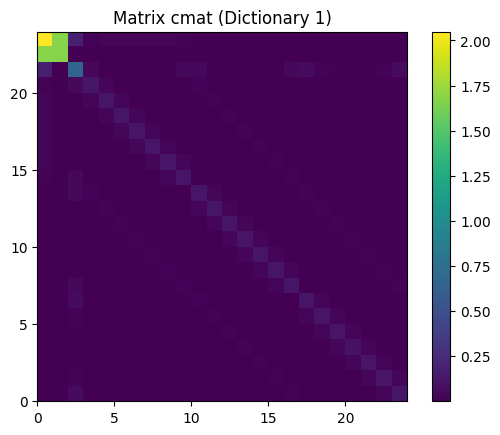

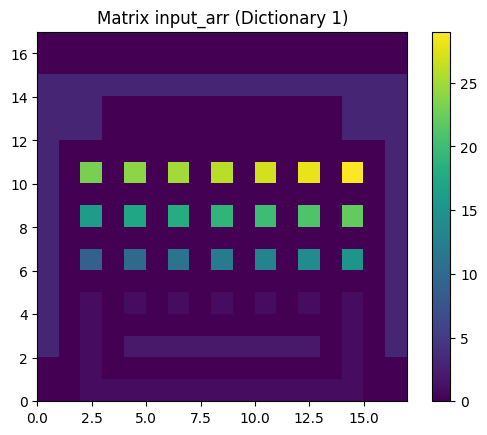

In [ ]:

if isinstance(data, list) and data:
    first_dictionary = data[0]

    # Print the keys of the first dictionary
    if isinstance(first_dictionary, dict):
        print("Keys of the first dictionary:", list(first_dictionary.keys()))

def visualize_matrix(data, index):
    """
    Visualize a matrix from the data at the given index.

    Parameters:
    data (list): List of dictionaries containing matrix data.
    index (int): Index of the dictionary to visualize.

    Returns:
    None
    """
    if isinstance(data, list) and data:
        if index < 0 or index >= len(data):
            print("Invalid index. Index should be within the range of the data list.")
            return

        dictionary = data[index]

        if isinstance(dictionary, dict):
            for key, matrix in dictionary.items():
                if isinstance(matrix, np.ndarray):
                    plt.figure()
                    plt.imshow(matrix, cmap='viridis', extent=[0, matrix.shape[1], 0, matrix.shape[0]])
                    plt.title(f'Matrix {key} (Dictionary {index+1})')
                    plt.colorbar()
                    plt.show()
                else:
                    print(f"Matrix for key {key} (Dictionary {index+1}) is not a valid NumPy array.")

visualize_matrix(data, 0)

Matrix for key file (Dictionary 2) is not a valid NumPy array.


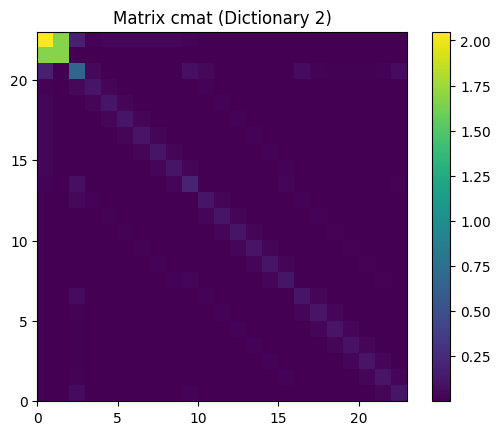

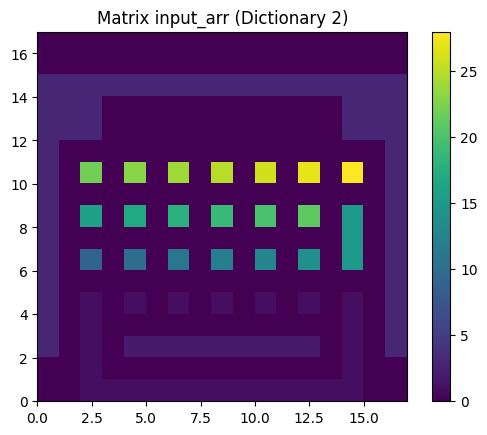

In [ ]:
visualize_matrix(data, 1)

At this point we are going to prepare a Machine learning model that must learn capacitance value as function of the patterns.

We have so far looked into :

    Data Format and Structure:
        What is the format of the raw data (e.g., images, text, numerical data)?
        How is the data structured (e.g., files, databases, APIs)?

Basics questions and steps we are going to go through :

    Data Preprocessing:
        What preprocessing steps are needed for this specific type of data (e.g., normalization, scaling, encoding)?
        Are there missing values, and how should they be handled (e.g., imputation, removal, special handling)?

    Data Loading and Batching:
        How will the data be loaded into memory or accessed during training (e.g., batches, streaming, data loaders)?
        What is the appropriate batch size for efficient training?

    Data Augmentation:
        Do we need to apply data augmentation techniques to increase the diversity of the training set (e.g., rotation, flipping, zooming for images)?
        How can data augmentation help in improving model generalization?

    Data Splitting:
        How should the data be split into training, validation, and testing sets (e.g., random split, stratified split)?
        What is the ratio or percentage for each set?

    Data Loading Performance:
        How can we optimize data loading for better performance during training (e.g., parallel loading, prefetching)?

    Memory and Resource Considerations:
        Do we have enough memory to load the entire dataset, or do we need to use methods like data streaming or mini-batching?

    Data Visualization:
        Are there specific visualizations that can help understand the data (e.g., histograms, images, class distributions)?

In [ ]:
class Pattern_dataset(Dataset):
    def __init__(self, aPattern_dataset):
        """
        Constructor for the Pattern_dataset class.

        Parameters:
        aPattern_dataset (list): List containing pattern dataset.

        Attributes:
        data (list): Pattern dataset.

        Initializes the Pattern_dataset instance with the provided pattern dataset.
        """
        super().__init__()  # Call the constructor of the inherited class
        self.data = aPattern_dataset

    def __len__(self):
        """
        Get the length of the dataset.

        Returns:
        int: Length of the dataset.

        Overrides the __len__ method from the inherited class to return the length of the dataset.
        """
        return len(self.data)

    def __getitem__(self, index):
        """
        Get a specific item from the dataset.

        Parameters:
        index (int): Index to retrieve the item from.

        Returns:
        torch.Tensor, torch.Tensor: Input and output tensors.

        Overrides the __getitem__ method from the inherited class to retrieve the input and output tensors
        corresponding to the given index.
        """

        # Input for regression and output of regression
        p, c = torch.tensor(self.data[index]['input_arr']).to(torch.float).to(device), \
               torch.tensor(self.data[index]['cmat']).to(torch.float).to(device)

        ph, pw = p.shape
        ch, cw = c.shape

        # Pad the input and output tensors to match specified dimensions
        padded_p = torch.nn.functional.pad(p, (0, 30 - pw, 0, 30 - ph)).unsqueeze(0)
        padded_c = torch.nn.functional.pad(c, (0, 20 - cw, 0, 20 - ch))

        return padded_p, padded_c

# Create an instance of the Pattern_dataset class with the provided data
pattern_data = Pattern_dataset(data)

# Get the length of the dataset
dataset_length = len(pattern_data)

# Get an example item from the dataset and print its shape
x, y = pattern_data[1]
print("Shape of input tensor (x):", x.shape)
print("Shape of output tensor (y):", y.shape)

Shape of input tensor (x): torch.Size([1, 30, 30])
Shape of output tensor (y): torch.Size([20, 20])


We are volontarily skipping the Data Preprocessing, as no specific analysis was conduced on these data but you shall feel free to arrange such if it bring benefit to your trainning.

    Data Preprocessing:
        What preprocessing steps are needed for this specific type of data (e.g., normalization, scaling, encoding)?
        Are there missing values, and how should they be handled (e.g., imputation, removal, special handling)?

    Data Loading and Batching:
        How will the data be loaded into memory or accessed during training (e.g., batches, streaming, data loaders)?
        What is the appropriate batch size for efficient training?

In [ ]:
# Create a DataLoader for the pattern dataset
from torch.utils.data import random_split

# Define the ratio for train and inference split (e.g., 60% train, 40% inference)
train_ratio = 0.6
inference_ratio = 1.0 - train_ratio

# Calculate the number of samples for each subset
train_size = int(train_ratio * len(pattern_data))
inference_size = len(pattern_data) - train_size

# Split the dataset
train_dataset, inference_dataset = random_split(pattern_data, [train_size, inference_size])

# Create DataLoaders for training and inference
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
inference_loader = DataLoader(dataset=inference_dataset, batch_size=32, shuffle=False)


We at this point need to define our Neural Network model, the instruction suggest here to use convolutional neural network with some default initialization parameters.

What makes CNN a good fit for such task ?
Based on the earlier learning how would you best implement such network ?

In [ ]:
# Hyper parameters
num_epochs = 500
num_classes = 10
batch_size = 32
learning_rate = 0.01

# Convolutional neural network with two convolutional layers
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        """
        Constructor for the ConvNet class.

        Parameters:
        num_classes (int): Number of output classes.

        Initializes the ConvNet model with specified number of output classes.
        """
        super(ConvNet, self).__init__()

        # First convolutional layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # 1 input channel, 16 output channels, 3x3 kernel
            nn.BatchNorm2d(16),  # Batch normalization
            nn.ReLU(),  # ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2))  # Max pooling

        # Second convolutional layer
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # 16 input channels, 32 output channels, 3x3 kernel
            nn.BatchNorm2d(32),  # Batch normalization
            nn.ReLU(),  # ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2))  # Max pooling

        # Fully connected layer
        self.fc = nn.Linear(1568, 20*20)  # Fully connected layer with output size 20*20

    def forward(self, x):
        """
        Forward pass of the ConvNet.

        Parameters:
        x (torch.Tensor): Input tensor.

        Returns:
        torch.Tensor: Output tensor.

        Defines the forward pass for the ConvNet.
        """
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)  # Flatten the output
        out = self.fc(out).reshape(-1, 20, 20)  # Fully connected layer and reshape
        return out

# Create an instance of the ConvNet model with 2 output classes
model = ConvNet(2)

# Move the model to the specified device (e.g., GPU)
model = model.to(torch.device(device))

# Print the model architecture
print("ConvNet Model:")
print(model)

# Define the optimizer for model parameters using Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)


ConvNet Model:
ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=400, bias=True)
)


An important aspect of machine learning regression is to define the loss function, in other words how the error will propagate.
we here indicate a Symmetric Mean absolute percentage error.
Please discuss this choice ?

In [ ]:
def SMAPE(a, b):
    """
    Calculate the Symmetric Mean Absolute Percentage Error (SMAPE) between tensors a and b.

    Parameters:
    a (torch.Tensor): Ground truth tensor.
    b (torch.Tensor): Predicted tensor.

    Returns:
    torch.Tensor: SMAPE loss.
    """
    return 2 * torch.mean(torch.abs(a - b) / (torch.abs(a) + torch.abs(b) + 1e-3))

In [ ]:
# Train the model
total_step = len(train_loader)  # Total number of batches in the dataset
losses = []  # List to store the losses during training

for epoch in range(num_epochs):
    for i, (pattern, caps) in enumerate(train_loader):

        pattern = pattern.to(device)  # Move pattern to the selected device (CPU/GPU)
        caps = caps.to(device)  # Move caps to the selected device (CPU/GPU)

        # Forward pass
        outputs = model(pattern)

        # Calculate SMAPE loss
        loss = SMAPE(caps, outputs)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())  # Store the loss for this batch

# Specify the file path to save the model
model_path = 'Capregression.pth'

# Save the model's state dictionary and other important components
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'losses': losses
}, model_path)



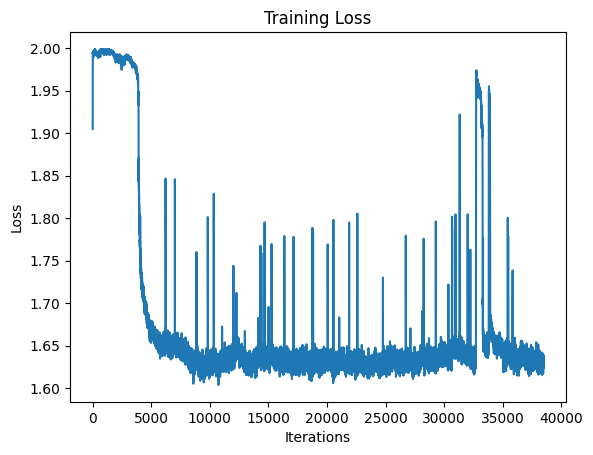

In [ ]:
# Plot losses
epochs = range(num_epochs * total_step)
plt.plot(epochs, losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
# Load the model
loaded_model = ConvNet(2)  # Assuming ConvNet is your model class
loaded_model = loaded_model.to(device)  # Move the model to the selected device (CPU/GPU)

# Load the saved model state dictionary
checkpoint = torch.load(model_path)
loaded_model.load_state_dict(checkpoint['model_state_dict'])

# Ensure the model is in evaluation mode for inference
loaded_model.eval()

# Initialize a list to store predicted values and ground truth
predictions = []
ground_truth = []

# Run inference and calculate error
with torch.no_grad():
    for i, (pattern, caps) in enumerate(inference_loader):
        pattern = pattern.to(device)
        caps = caps.to(device)

        # Forward pass
        outputs = model(pattern)

        # Append predictions and ground truth
        predictions.append(outputs.cpu().numpy())  # Convert to numpy array and move to CPU
        ground_truth.append(caps.cpu().numpy())  # Convert to numpy array and move to CPU

# Concatenate the predictions and ground truth
predictions = np.concatenate(predictions)
ground_truth = np.concatenate(ground_truth)

# Calculate the SMAPE error
inference_smape = SMAPE(torch.tensor(ground_truth), torch.tensor(predictions))

print("SMAPE on inference set:", inference_smape.item())


SMAPE on inference set: 1.6293962001800537


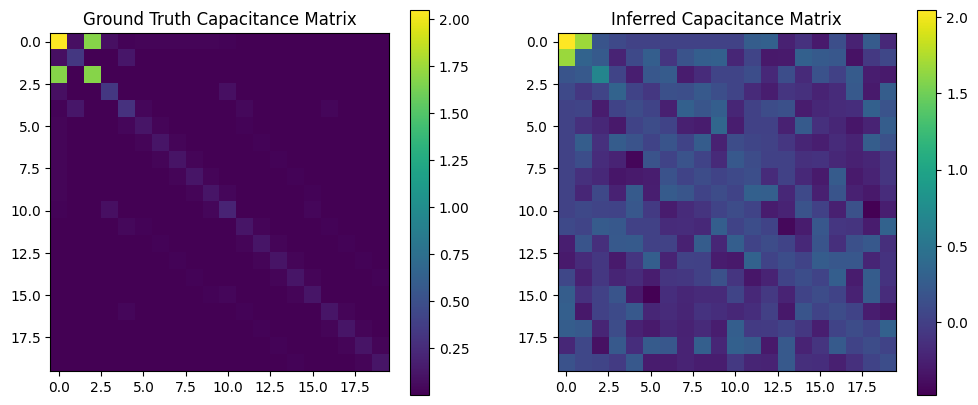

In [ ]:
# Initialize variables to store errors and corresponding samples
errors = []
sample_indices = []

# Set the model to evaluation mode
model.eval()

# Run inference and calculate error for each sample
with torch.no_grad():
    for i, (pattern, caps) in enumerate(inference_loader):
        pattern = pattern.to(device)
        caps = caps.to(device)

        # Forward pass
        outputs = model(pattern)

        # Calculate SMAPE error for this sample
        error = SMAPE(caps, outputs).item()

        # Store the error and sample index
        errors.append(error)
        sample_indices.append(i)

# Find the index of the sample with the highest error
worst_sample_index = sample_indices[np.argmax(errors)]

# Get the pattern and ground truth for the worst sample
worst_pattern, worst_caps = inference_dataset[worst_sample_index]

# Forward pass for the worst sample
worst_outputs = model(worst_pattern.unsqueeze(0).to(device))
worst_outputs = worst_outputs.detach().cpu().numpy()

# Plot the capacitance matrix for the worst sample
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(worst_caps.squeeze(), cmap='viridis')
plt.title('Ground Truth Capacitance Matrix')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(worst_outputs.squeeze(), cmap='viridis')
plt.title('Inferred Capacitance Matrix')
plt.colorbar()

plt.show()